# Adstock Campaign Attribution Model
Adstock model helps to estimate the contribution of individual campaigns to overall financial performance.

In [1]:
%matplotlib inline
import sympy as sy
import numpy as np
from mpmath import *
from scipy.optimize import minimize
import matplotlib.pyplot as plt

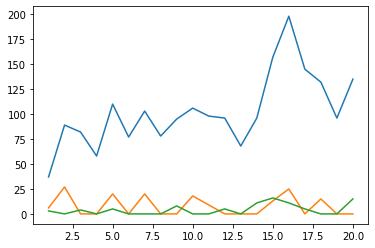

In [4]:
# The input of the model is a sequence of samples (time series) 
# where each sample is represented by three values:
#  - Total revenue
#  - Intensity of campaign 01
#  - Intensity of campaign 02
revenue_series = [37, 89, 82, 58, 110, 77, 103, 78, 95, 106, 98, 96, 68, 96, 157, 198, 145, 132, 96, 135]
campaign_series_01 = [6, 27, 0, 0, 20, 0, 20, 0, 0, 18, 9, 0, 0, 0, 13, 25, 0, 15, 0, 0]
campaign_series_02 = [3, 0, 4, 0, 5, 0, 0, 0, 8, 0, 0, 5, 0, 11, 16, 11, 5, 0, 0, 15]
decay_length = 3
time = range(1, len(revenue_series)+1)
plt.plot(time, revenue_series, time, campaign_series_01, time, campaign_series_02);

In [5]:
# Adds a time lag (memory effect) to the campaign intensity samples 
def lag(campaing_series, alpha, decay_lenght):
    lag_series = []
    for t in range(1, len(campaing_series)+1):
        lag_series.append( 
            campaing_series[t-1] + 
            nsum(lambda j: alpha**j * campaing_series[int(t-1-j)], [1, min(t, decay_lenght)]) 
        )
    return lag_series

In [6]:
# Apply a time lag to the campaign intensity data, and then 
# define the Adstock model as a linear function of lagged samples.
# The model training objective is to minimize the approximation error
symbols = sy.symbols("b w1 w2 a1 a2")
b, w1, w2, a1, a2 = symbols
campaing_lag_01 = sy.Matrix(lag(campaign_series_01, a1, decay_length))
campaing_lag_02 = sy.Matrix(lag(campaign_series_02, a2, decay_length))
revenue_series_model = sy.Matrix([b]*len(time)) + w1*campaing_lag_01 + w2*campaing_lag_02
objective = (sy.Matrix(revenue_series) - revenue_series_model).norm()

In [7]:
# Each sample of the revenue series is approximated by a polynomial of several 
# campaing intensity samples
revenue_series_model

Matrix([
[                                                b + 6.0*w1 + w2*(15*a2**1.0 + 3)],
[                           b + w1*(6*a1**1.0 + 27) + w2*(3*a2**1.0 + 15*a2**2.0)],
[               b + w1*(27*a1**1.0 + 6*a1**2.0) + w2*(3*a2**2.0 + 15*a2**3.0 + 4)],
[                    b + w1*(27*a1**2.0 + 6*a1**3.0) + w2*(4*a2**1.0 + 3*a2**3.0)],
[                                   b + w1*(27*a1**3.0 + 20) + w2*(4*a2**2.0 + 5)],
[                                  20*a1**1.0*w1 + b + w2*(5*a2**1.0 + 4*a2**3.0)],
[                                         5*a2**2.0*w2 + b + w1*(20*a1**2.0 + 20)],
[                                 5*a2**3.0*w2 + b + w1*(20*a1**1.0 + 20*a1**3.0)],
[                                                      20*a1**2.0*w1 + b + 8.0*w2],
[                                         8*a2**1.0*w2 + b + w1*(20*a1**3.0 + 18)],
[                                          8*a2**2.0*w2 + b + w1*(18*a1**1.0 + 9)],
[                            b + w1*(9*a1**1.0 + 18*a1**2.0) + w2*(

In [9]:
# Adstock model fitting using numerical optimization
objective_n = sy.lambdify(symbols, objective, modules='numpy')
def objective_v(x):
    return objective_n(*tuple(x))

solution = minimize(objective_v, np.zeros(len(symbols)))
bn, w1n, w2n, a1n, a2n = solution.x

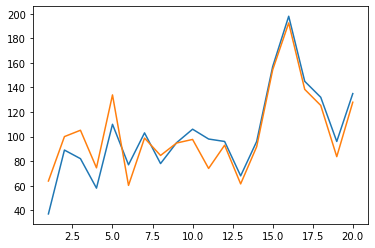

In [10]:
# Plot the difference between the actual revenue data and adstock model
revenue_predicted = sy.lambdify(symbols, revenue_series_model)
revenue_predicted_series = revenue_predicted(*tuple(solution.x))
plt.plot(time, revenue_series, time, revenue_predicted_series);

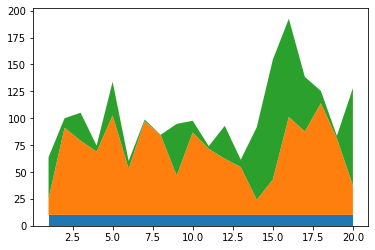

In [11]:
# Evaluate and plot model components that correspond to individual campaigns 
# (i.e. estimate contribution of individual campaigns)
def eval_campaing_lag(campaing_lag, a, aval, w):
    return sy.matrix2numpy(w*campaing_lag.evalf(subs={a:aval}), dtype=float).flatten().tolist()
    
plt.stackplot(time, [ 
    [bn]*len(time), 
    eval_campaing_lag(campaing_lag_01, a1, a1n, w1n),
    eval_campaing_lag(campaing_lag_02, a2, a2n, w2n)
] );